### Find the Unit of the corresponding welllogs

In [1]:
import os
import lasio
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np
from tqdm import tqdm
warnings.filterwarnings('ignore')
from datetime import datetime


selected_logs = set(['SP', 'RLL3', 'GR', 'RILD', 'RILM', 'DCAL', 'RHOB', 'RHOC', 'DPOR', 'CNPOR'])
yeas = 2023
file_path_dir = os.path.join('DataArchive', str(yeas))
well_list = list(filter(lambda x: x.endswith('.las'), os.listdir(file_path_dir)))

format1 = '%m/%d/%Y'
format2 = '%a %b %d %H-%M-%S %Y'

useful_well = {}

for well in well_list:
    try:
        well_path = os.path.join(file_path_dir, well)
        df = lasio.read(well_path)
        log_date = df.well.DATE.value
        try:
            log_date = datetime.strptime(log_date, format1)
        except:
            log_date = datetime.strptime(log_date, format2)
        df = df.df()
        columns = df.columns
        if selected_logs.issubset(set(columns)):
            useful_well[well] = log_date
    except:
        continue


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
sorted_well = sorted(useful_well.items(), key=lambda x: x[1])
train_validation_test_ratio = [0.7, 0.2, 0.1]
train_wells = sorted_well[:int(len(sorted_well) * train_validation_test_ratio[0])]
validation_wells = sorted_well[int(len(sorted_well) * train_validation_test_ratio[0]): int(len(sorted_well) * (train_validation_test_ratio[0] + train_validation_test_ratio[1]))]
test_wells = sorted_well[int(len(sorted_well) * (train_validation_test_ratio[0] + train_validation_test_ratio[1])):]

train_well_las = [x[0] for x in train_wells]
validation_well_las = [x[0] for x in validation_wells]
test_well_las = [x[0] for x in test_wells]
selected_logs = ['SP', 'RLL3', 'GR', 'RILD', 'RILM', 'DCAL', 'RHOB', 'RHOC', 'DPOR', 'CNPOR']
for well in train_well_las:
    well_path = os.path.join(file_path_dir, well)
    df = lasio.read(well_path).df()[selected_logs]
    df = df[df.index * 10 % 5 == 0]
    if not os.path.exists('./raw_dataset/train'):
        os.makedirs('./raw_dataset/train')
    df.to_csv(os.path.join('./raw_dataset/train', well[:-4] + '.csv'))

for well in validation_well_las:
    well_path = os.path.join(file_path_dir, well)
    df = lasio.read(well_path).df()[selected_logs]
    df = df[df.index * 10 % 5 == 0]
    if not os.path.exists('./raw_dataset/valid'):
        os.makedirs('./raw_dataset/valid')
    df.to_csv(os.path.join('./raw_dataset/valid', well[:-4] + '.csv'))

for well in test_well_las:
    well_path = os.path.join(file_path_dir, well)
    df = lasio.read(well_path).df()[selected_logs]
    df = df[df.index * 10 % 5 == 0]
    if not os.path.exists('./raw_dataset/test'):
        os.makedirs('./raw_dataset/test')
    df.to_csv(os.path.join('./raw_dataset/test', well[:-4] + '.csv'))


### data preprocessing and rescalering. 

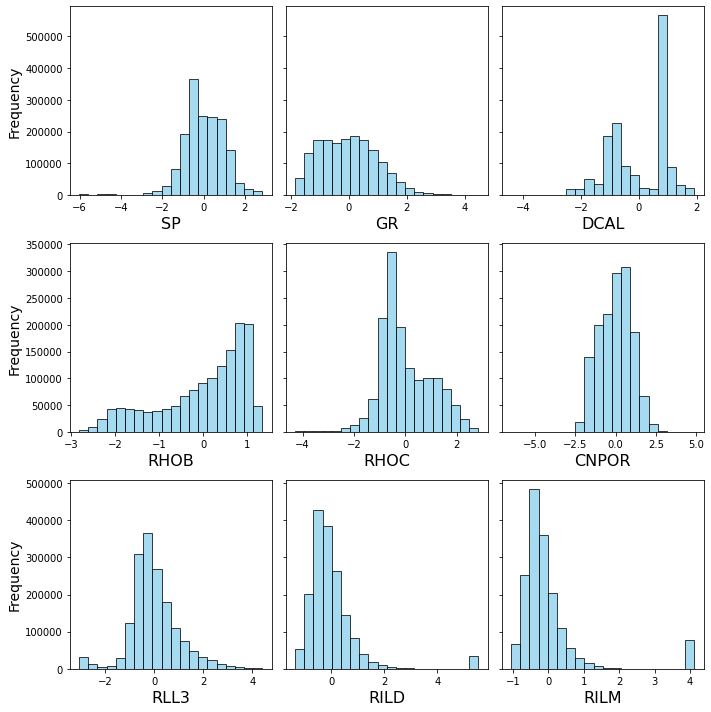

In [4]:
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# from dataset.WellLogDataLoader import WellLogDataset

log_save_paths = ['./raw_dataset/train/', './raw_dataset/test/', './raw_dataset/valid/']
all_logs = [pd.read_csv(os.path.join(log_save_path, log)) for log_save_path in log_save_paths for log in os.listdir(log_save_path) if log.endswith('.csv')]
all_logs = pd.concat(all_logs, axis=0).drop(['DEPT', 'DPOR'], axis=1)
raw_all_logs = all_logs.copy()
origin_columns = all_logs.columns


columns = ['SP', 'GR', 'DCAL', 'RHOB', 'RHOC', 'CNPOR', 'RLL3', 'RILD', 'RILM']
all_logs['RLL3'] = np.log(all_logs['RLL3'])
all_logs['RILD'] = np.log(all_logs['RILD'])
all_logs['RILM'] = np.log(all_logs['RILM'])

boundary = {}
for col in ['SP', 'GR', 'DCAL', 'RHOB', 'RHOC']:
    q_low = all_logs[col].quantile(0.005)
    q_hi  = all_logs[col].quantile(0.995)
    boundary[col] = [q_low, q_hi]
    all_logs[col] = all_logs[col].mask(all_logs[col] < q_low, np.nan)
    all_logs[col] = all_logs[col].mask(all_logs[col] > q_hi, np.nan)

for col in ['RLL3', 'RILD', 'RILM']:
    q_low = all_logs[col].quantile(0.005)
    q_hi  = all_logs[col].quantile(0.995)
    boundary[col] = [q_low, q_hi]
    all_logs[col] = all_logs[col].mask(all_logs[col] < q_low, np.nan)
    all_logs[col] = all_logs[col].mask(all_logs[col] > q_hi, np.nan)

standarscaler = StandardScaler().fit(all_logs)
standard_normalised_all_logs = standarscaler.transform(all_logs)
standard_normalised_all_logs = pd.DataFrame(standard_normalised_all_logs, columns=origin_columns)

feat = standard_normalised_all_logs.shape[1]
fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharey='row')
for i in range(feat):
    sns.histplot(standard_normalised_all_logs[columns[i]], bins=20, color='skyblue', ax=ax[i//3, i % 3], edgecolor='black')
    ax[i//3, i % 3].set_xlabel(f"{columns[i]}", fontsize=16,)
    ax[i//3, i % 3].set_ylabel('Frequency', fontsize=14)
plt.tight_layout()
# plt.savefig('./materials/PostPreprocessddistribution.pdf')

### remove the outliner and save the resulting data into ./dataset/train/ .. 

In [5]:
log_save_paths = ['./raw_dataset/train/', './raw_dataset/test/', './raw_dataset/valid/']
for dir in log_save_paths:
    for logs in os.listdir(os.path.join(dir)):
        if logs.endswith('.csv'):
            df = pd.read_csv(os.path.join(dir, logs))
            df['RLL3'] = np.log(df['RLL3'])
            df['RILD'] = np.log(df['RILD'])
            df['RILM'] = np.log(df['RILM'])

            for keys in df.columns:
                # remove the outliers
                for keys in boundary:
                    q_low = boundary[keys][0]
                    q_hi  = boundary[keys][1]
                    df[keys] = df[keys].mask(df[keys] < q_low, np.nan)
                    df[keys] = df[keys].mask(df[keys] > q_hi, np.nan)

            logs_save_path = os.path.join('./ProcessedDataset/', dir.split('/')[-2], logs)

            if not os.path.exists(os.path.dirname(logs_save_path)):
                os.makedirs(os.path.dirname(logs_save_path))
            df.to_csv(logs_save_path, index=False)

### calculate the missing ratio of the final dataset

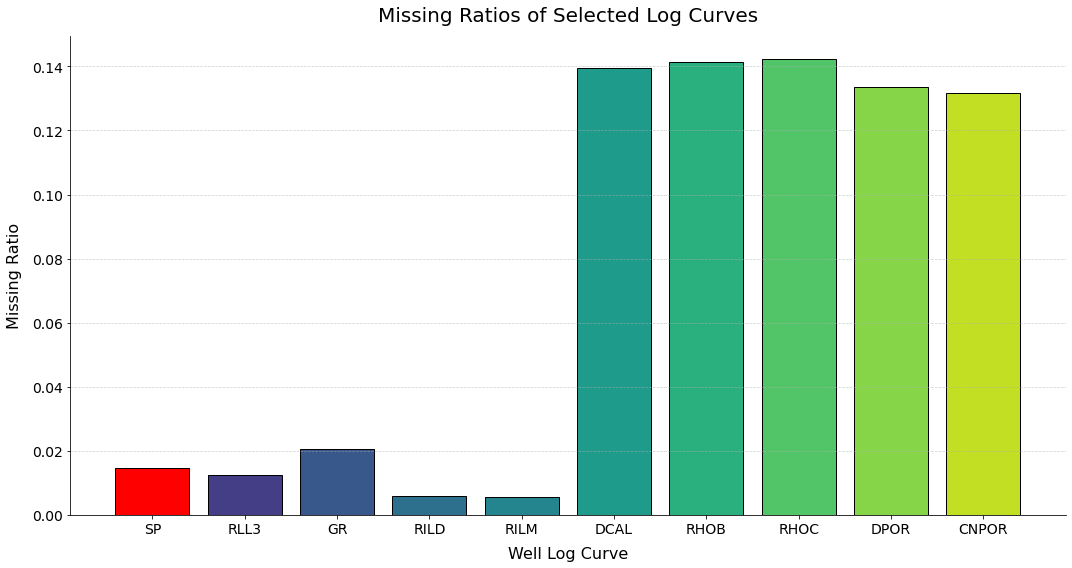

In [8]:
log_save_paths = ['./ProcessedDataset/train/', './ProcessedDataset/test/', './ProcessedDataset/valid/']
all_logs = [pd.read_csv(os.path.join(log_save_path, log)) for log_save_path in log_save_paths for log in os.listdir(log_save_path)]
all_logs = pd.concat(all_logs, axis=0).drop('DEPT', axis=1)
missing_ratio = all_logs.isnull().sum(axis=0)/all_logs.shape[0]

labels = missing_ratio.index
values = missing_ratio.values

# Plot
plt.figure(figsize=(15, 8))
bars = plt.bar(labels, values, color=sns.color_palette("viridis", len(labels)), edgecolor='black')
plt.title('Missing Ratios of Selected Log Curves', fontsize=20, pad=15)
plt.xlabel('Well Log Curve', fontsize=16, labelpad=10)
plt.ylabel('Missing Ratio', fontsize=16, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
sns.despine(top=True, right=True)  # Remove top and right spines for aesthetics

# Highlight the bar with the highest count
bars[0].set_color('red')
bars[0].set_edgecolor('black')

plt.tight_layout()
plt.savefig('./materials/missingratio.pdf', bbox_inches='tight')
# plt.close()

### visualisation locations for the training validatiaon and test wells. 

In [9]:
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import numpy as np
import seaborn as sns
well_information_detail = pd.read_csv('./DataArchive/ks_las_files.txt')
well_information_detail['wellid'] = well_information_detail['URL'].apply(lambda x: x.split('/')[-1][:-4])
well_reported_2023_file_list = [file for file in os.listdir('./DataArchive/2023') if file.endswith('.las')]
train_wells = [file[:-4] for file in os.listdir('./ProcessedDataset/train/') if file.endswith('.csv')]
test_wells = [file[:-4] for file in os.listdir('./ProcessedDataset/test/') if file.endswith('.csv')]
valid_wells = [file[:-4] for file in os.listdir('./ProcessedDataset/valid/') if file.endswith('.csv')]

train_Longitude = [well_information_detail[well_information_detail['wellid'] == well]['Longitude'].values for well in train_wells]
train_Latitude = [well_information_detail[well_information_detail['wellid'] == well]['Latitude'].values for well in train_wells]
test_Longitude = [well_information_detail[well_information_detail['wellid'] == well]['Longitude'].values for well in test_wells]
test_Latitude = [well_information_detail[well_information_detail['wellid'] == well]['Latitude'].values for well in test_wells]
valid_Longitude = [well_information_detail[well_information_detail['wellid'] == well]['Longitude'].values for well in valid_wells]
valid_Latitude = [well_information_detail[well_information_detail['wellid'] == well]['Latitude'].values for well in valid_wells]

import folium
import numpy as np

from branca.element import MacroElement
from jinja2 import Template

# Custom ScaleBar class
class ScaleBar(MacroElement):
    def __init__(self):
        super(ScaleBar, self).__init__()
        self._template = Template("""
        {% macro script(this, kwargs) %}
            var {{this.get_name()}} = L.control.scale().addTo({{this._parent.get_name()}});
        {% endmacro %}
        """)

# Create a base map
m = folium.Map(location=[38.5, -98.5], zoom_start=5)

# Add points to the map
for lon, lat in zip(train_Longitude, train_Latitude):
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        color="blue",
        fill=True,
        fill_color="blue",
    ).add_to(m)

for lon, lat in zip(valid_Longitude, valid_Latitude):
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        color="red",
        fill=True,
        fill_color="red",
    ).add_to(m)

for lon, lat in zip(test_Longitude, test_Latitude):
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        color="green",
        fill=True,
        fill_color="green",
    ).add_to(m)

m.add_child(ScaleBar())

# Save map to HTML file
m.save("./materials/map.html")